# W266 Final Project Basline Modeling
In this notebook, I implement the three described in *Twitch Emote Prediction: Extensions and Benchmarking using Transformers*.
1. Most-common-class-predictor
2. Long Short-Term Memory (LSTM) network
3. Bi-directional LSTM (B-LSTM) network

## 1. Setup
First, import libraries & data.

In [3]:
# Import libraries
!pip install gensim==3.8.3 --quiet
!pip install tensorflow tensorflow-text --quiet

from google.colab import files
import io
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_text as tf_text
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.data import find
import gensim

In [4]:
# Read the data
uploaded = files.upload()

Saving top_30_emotes.csv to top_30_emotes.csv


In [5]:
df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))
df.rename(columns={"label": "label_name"}, inplace=True)
df.head(5)

<ipython-input-5-5366ad058dd5>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(uploaded['top_30_emotes.csv']))


,commenter_id,commenter_name,user_type,message_time,message_type,streamer,video_date,video_id,message_length,message,input,label_name
0,23261972.0,qrass,User,2023-03-11T18:05:21.218Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,3,no skipper stream Sadge,no skipper stream,Sadge
1,160455408.0,moby_drip,User,2023-03-11T18:05:42.405Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,4,3 second skippy stream Pog,3 second skippy stream,Pog
2,39897326.0,charmiee,User,2023-03-11T18:06:01.633Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,8,u got the wrong channel at first mate LUL,u got the wrong channel at first mate,LUL
3,115717981.0,just__ok,User,2023-03-11T18:06:31.622Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,4,Sadge not at streamer awards,not at streamer awards,Sadge
4,28841240.0,Karaszan,User,2023-03-11T18:06:53.793Z,VideoCommentMessage,sodapoppin,2023-03-11T18:05:06Z,1762238696,10,Is it real this time? @sodapoppin :D No Stream...,Is it real this time? @sodapoppin :D No Stream...,Sadge


In [6]:
# Number of VODs collected per streamer
df.groupby('streamer')['video_id'].nunique().sort_values(ascending=False)[:10]

streamer
esl_csgo           18
xqc                18
hasanabi           17
fextralife         17
rainbow6           16
forsen             16
nmplol             16
clix               16
tsm_imperialhal    16
summit1g           15
Name: video_id, dtype: int64

In [7]:
# Get number of chat messages per streamer in corpus
streamer_counts = df[['streamer']].groupby(['streamer'])['streamer'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
print('Number of streamers:', len(streamer_counts))
print('Average messages per streamer:', streamer_counts["count"].mean())
streamer_counts

Number of streamers: 93
Average messages per streamer: 9234.086021505376


,streamer,count
27,forsen,92871
43,lec,82374
33,hasanabi,66891
88,xqc,53476
38,kaicenat,52015
...,...,...
20,eamaddennfl,89
84,unboxholics,88
17,cxmmunity,59
5,brawlhalla,32


## Data Preprocessing
- Lower case text (already experimented with keeping case in BERT and it wasn't improving the performance, but could do further experimentation with extended vocabulary)
- String index labels
- Train/test & train/validation splits

In [8]:
emote_counts = df[['label_name']].groupby(['label_name'])['label_name'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
emote_counts

,label_name,count
9,KEKW,184087
12,LUL,177796
18,Pog,61591
22,Sadge,46814
7,FeelsBadMan,36106
10,Kappa,28720
8,FeelsGoodMan,28670
16,PepeLaugh,26186
26,YEP,22640
20,PogU,20375


In [9]:
df = pd.merge(df, emote_counts, on="label_name")

In [10]:
# Lower case input column
df['input'] = df['input'].str.lower()

In [11]:
# String index the label names
le = LabelEncoder()
df['label'] = le.fit_transform(df['label_name'])

# You can reverse this encoding: le.inverse_transform([9, 10, 1, 2])
target_names = le.inverse_transform(range(30))
print(target_names)

['4Head' '4Weird' '5Head' 'AYAYA' 'BibleThump' 'DansGame' 'FailFish'
 'FeelsBadMan' 'FeelsGoodMan' 'KEKW' 'Kappa' 'Kreygasm' 'LUL'
 'MorphinTime' 'NotLikeThis' 'PauseChamp' 'PepeLaugh' 'Pepega' 'Pog'
 'PogChamp' 'PogU' 'ResidentSleeper' 'Sadge' 'SwiftRage' 'TriHard'
 'WeirdChamp' 'YEP' 'gachiBASS' 'monkaOMEGA' 'widepeepoHappy']


In [12]:
messages = df.input
labels = df.label

# Split into train & test
train_texts, test_texts, train_labels, test_labels = train_test_split(messages, labels, test_size=0.2, random_state=123)
print(len(train_texts))
print(len(test_texts))

687016
171754


In [13]:
train_texts[:5]

321220     @kali8000, you dont have any points to roulette 
792127                               blahspam13,  hi bestie
343906     eu still awake  eu still awake  eu still awak...
823620     spam  this  static  to  help  fnatic   spam  ...
248424    bunch of little guys saying heavyweights get t...
Name: input, dtype: object

In [14]:
train_labels[:5]

321220     7
792127    29
343906     7
823620    13
248424    12
Name: label, dtype: int64

Let's explicitly set aside part of our training set for validation purposes.



In [15]:
# Validation split is about 85/15 split
valid_texts = train_texts[600000:] 
valid_labels = train_labels[600000:]
train_texts = train_texts[:600000]
train_labels = train_labels[:600000]

print(len(train_texts)) # Always 600,000
print(len(valid_texts))

600000
87016


## 2. Baseline Model: Most-common-class predictor

In [16]:
majority = train_labels.mode()[0]
print('Majority class:', majority)
print('Majority class name:', le.inverse_transform([majority]))

Majority class: 9
Majority class name: ['KEKW']


In [17]:
# Predict for train
test_predictions = np.empty(len(test_texts))
test_predictions.fill(majority)

In [18]:
# Compare the first 5 predictions
test_compare = pd.DataFrame(test_labels.copy())
test_compare['prediction'] = test_predictions.astype(int)
test_compare.head(5)

,label,prediction
420784,9,9
341594,7,9
479490,9,9
281769,12,9
578999,16,9


In [19]:
print(classification_report(test_labels, test_predictions, target_names=target_names))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          4Head       0.00      0.00      0.00      1916
         4Weird       0.00      0.00      0.00       928
          5Head       0.00      0.00      0.00      1019
          AYAYA       0.00      0.00      0.00      3555
     BibleThump       0.00      0.00      0.00      2838
       DansGame       0.00      0.00      0.00      1703
       FailFish       0.00      0.00      0.00      1507
    FeelsBadMan       0.00      0.00      0.00      7153
   FeelsGoodMan       0.00      0.00      0.00      5694
           KEKW       0.22      1.00      0.36     37165
          Kappa       0.00      0.00      0.00      5683
       Kreygasm       0.00      0.00      0.00      2239
            LUL       0.00      0.00      0.00     35572
    MorphinTime       0.00      0.00      0.00      3592
    NotLikeThis       0.00      0.00      0.00      3347
     PauseChamp       0.00      0.00      0.00      1782
      PepeLaugh       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. Model 1: LSTM

In [21]:

# !pip install gensim==4.1.2
import gensim.downloader

In [22]:
vocab_model = gensim.downloader.load('glove-wiki-gigaword-50')
len(vocab_model.vocab)

[==================================================] 100.0% 66.0/66.0MB downloaded


400000

In [23]:
# Build embedding matrix and vocab dictionary
EMBEDDING_DIM = len(vocab_model['university'])

# Initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(vocab_model.vocab.keys()) + 1, EMBEDDING_DIM))       
vocab_dict = {}

# Build the embedding matrix and the word-to-id map:
for i, word in enumerate(vocab_model.vocab.keys()):
    embedding_vector = vocab_model[word]

    if embedding_vector is not None:
        # Words not found in embedding index will be zero
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# We can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [24]:
embedding_matrix.shape

(400001, 50)

In [25]:
# Future work: regex to space out punctuation before tokenizer

tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_texts)
valid_tokens = tokenizer.tokenize(valid_texts)
test_tokens = tokenizer.tokenize(test_texts)

In [27]:
MAX_SEQUENCE_LENGTH = 32

In [28]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [30]:
train_input = docs_to_vocab_ids(train_tokens)
valid_input = docs_to_vocab_ids(valid_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Examples processed:  30000
Examples processed:  35000
Examples processed:  40000
Examples processed:  45000
Examples processed:  50000
Examples processed:  55000
Examples processed:  60000
Examples processed:  65000
Examples processed:  70000
Examples processed:  75000
Examples processed:  80000
Examples processed:  85000
Examples processed:  90000
Examples processed:  95000
Examples processed:  100000
Examples processed:  105000
Examples processed:  110000
Examples processed:  115000
Examples processed:  120000
Examples processed:  125000
Examples processed:  130000
Examples processed:  135000
Examples processed:  140000
Examples processed:  145000
Examples processed:  150000
Examples processed:  155000
Examples processed:  160000
Examples processed:  165000
Examples processed:  170000
Examples processed:  175000
Examples processe

In [31]:
train_tokens[:5]

<tf.RaggedTensor [[b'@kali8000,', b'you', b'dont', b'have', b'any', b'points', b'to',
  b'roulette']                                                      ,
 [b'blahspam13,', b'hi', b'bestie'],
 [b'eu', b'still', b'awake', b'eu', b'still', b'awake', b'eu', b'still',
  b'awake', b'eu', b'still', b'awake', b'eu', b'still', b'awake', b'.'] ,
 [b'spam', b'this', b'static', b'to', b'help', b'fnatic', b'spam', b'this',
  b'static', b'to', b'help', b'fnatic']                                    ,
 [b'bunch', b'of', b'little', b'guys', b'saying', b'heavyweights', b'get',
  b'tkod', b'cause', b'they', b'tired']                                   ]>

In [32]:
train_input[:5]

array([[400000,     81,  46768,     33,    130,    226,      4,  33476,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000],
       [400000,  11083, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000],
       [   644,    149,  16856,    644,    149,  16856,    644,    149,
         16856,    644,    149,  16856,    644,    149,  16856,      2,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000],
       [ 16391,     37,  13173,      4,    275, 285730,  16391,     37,
         13173,      4,    275, 285730, 400000, 400000, 40000

In [33]:
train_labels[:5]

array([ 7, 29,  7, 13, 12])

In [34]:
from tensorflow.keras.layers import Embedding

def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(30, activation='softmax')(last_hidden_output) # Change to numclasses (30)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # 'categorical_crossentropy'?
                      metrics=['accuracy'])
    return rnn_model

In [35]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

rnn_model = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)


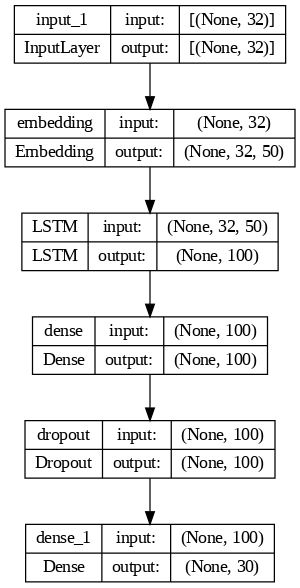

In [36]:
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [37]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(valid_input, valid_labels),
                            batch_size=32,
                            epochs=15
                            )

Epoch 1/15
18750/18750 [==============================] - 103s 5ms/step - loss: 2.2773 - accuracy: 0.3293 - val_loss: 2.1153 - val_accuracy: 0.3614
Epoch 2/15
18750/18750 [==============================] - 96s 5ms/step - loss: 2.0853 - accuracy: 0.3771 - val_loss: 2.0246 - val_accuracy: 0.3898
Epoch 3/15
18750/18750 [==============================] - 99s 5ms/step - loss: 2.0197 - accuracy: 0.3928 - val_loss: 1.9893 - val_accuracy: 0.3979
Epoch 4/15
18750/18750 [==============================] - 96s 5ms/step - loss: 1.9842 - accuracy: 0.4017 - val_loss: 1.9636 - val_accuracy: 0.4019
Epoch 5/15
18750/18750 [==============================] - 101s 5ms/step - loss: 1.9607 - accuracy: 0.4081 - val_loss: 1.9458 - val_accuracy: 0.4090
Epoch 6/15
18750/18750 [==============================] - 96s 5ms/step - loss: 1.9422 - accuracy: 0.4131 - val_loss: 1.9338 - val_accuracy: 0.4152
Epoch 7/15
18750/18750 [==============================] - 100s 5ms/step - loss: 1.9264 - accuracy: 0.4172 - val_loss

In [38]:
test_predictions = rnn_model.predict(test_input)

5368/5368 [==============================] - 13s 2ms/step


In [39]:
test_predictions

array([[0.00576119, 0.00048906, 0.0076204 , ..., 0.00103691, 0.00287777,
        0.00259802],
       [0.00300993, 0.00117235, 0.0046121 , ..., 0.00675742, 0.00310519,
        0.02213331],
       [0.00679855, 0.00822339, 0.00735094, ..., 0.00625104, 0.02589566,
        0.00704895],
       ...,
       [0.00374266, 0.00309647, 0.00451365, ..., 0.00978693, 0.0111189 ,
        0.0235314 ],
       [0.00116858, 0.00806512, 0.00185918, ..., 0.04772584, 0.0515453 ,
        0.00938944],
       [0.0090805 , 0.00142146, 0.01319754, ..., 0.0007551 , 0.00040223,
        0.00441256]], dtype=float32)

In [40]:
# Get the highest probability in the distribution for each prediction
test_predictions = tf.argmax(test_predictions, axis=-1)

In [41]:
print(classification_report(test_labels, test_predictions.numpy(), target_names=target_names))

                 precision    recall  f1-score   support

          4Head       0.54      0.52      0.53      1916
         4Weird       0.55      0.24      0.33       928
          5Head       1.00      0.02      0.03      1019
          AYAYA       0.67      0.40      0.50      3555
     BibleThump       0.49      0.08      0.14      2838
       DansGame       0.53      0.21      0.30      1703
       FailFish       0.76      0.26      0.39      1507
    FeelsBadMan       0.90      0.72      0.80      7153
   FeelsGoodMan       0.93      0.78      0.85      5694
           KEKW       0.34      0.67      0.45     37165
          Kappa       0.95      0.02      0.04      5683
       Kreygasm       0.60      0.14      0.23      2239
            LUL       0.32      0.39      0.35     35572
    MorphinTime       1.00      0.97      0.98      3592
    NotLikeThis       0.72      0.03      0.06      3347
     PauseChamp       0.71      0.07      0.12      1782
      PepeLaugh       0.68    

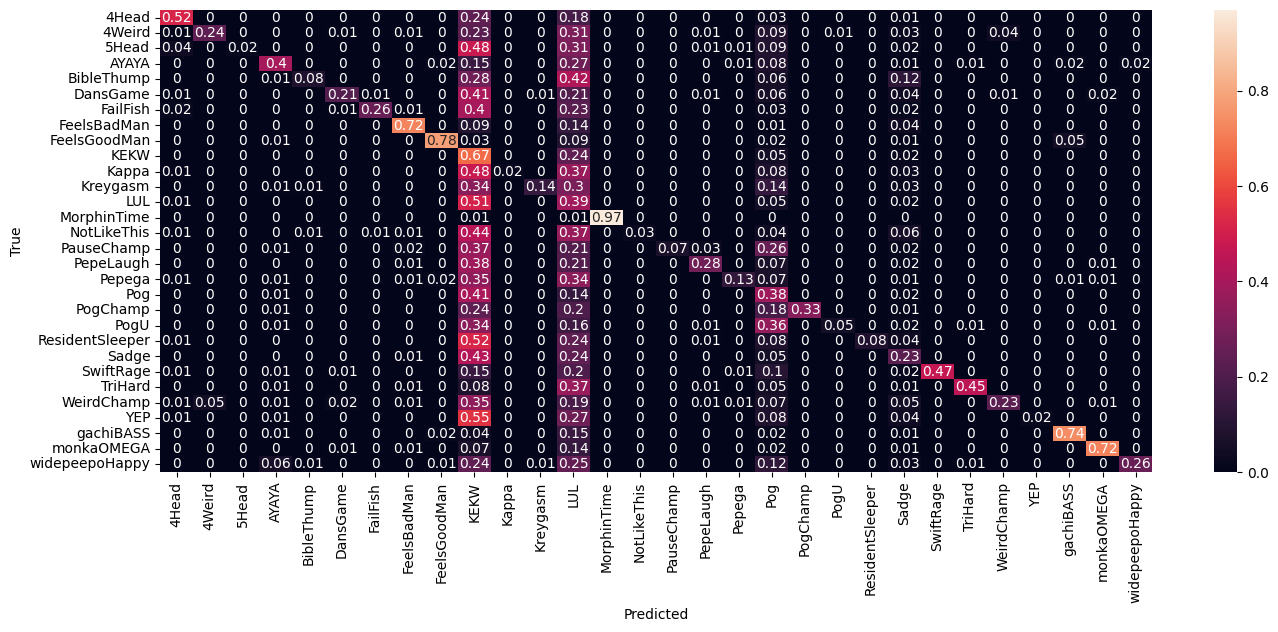

In [42]:
cm = tf.math.confusion_matrix(test_labels, test_predictions)
cm = np.around(cm/cm.numpy().sum(axis=1)[:, tf.newaxis], decimals=2)

plt.figure(figsize=(16,6))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [43]:
# Test some custom inputs into the model for model comparison
example = ['any second now']

example_tokens = tokenizer.tokenize(example)
example_input = docs_to_vocab_ids(example_tokens)
example_prediction = rnn_model.predict(example_input)

example_prediction = tf.argmax(example_prediction , axis=-1)
example_prediction

le.inverse_transform(example_prediction)

Examples processed:  0
Total examples:  0
1/1 [==============================] - 0s 53ms/step


array(['KEKW'], dtype=object)

## Model 2: B-LSTM

In [44]:
from tensorflow.keras.layers import Embedding

def build_bilstm_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # Bidirectional LSTM layer
    rnn_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM'))\
        (rnn_embeddings)   

    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(30, activation='softmax')(last_hidden_output) # Change to numclasses (30)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # 'categorical_crossentropy'?
                      metrics=['accuracy'])
    return rnn_model

In [45]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

bilstm_model = build_bilstm_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)


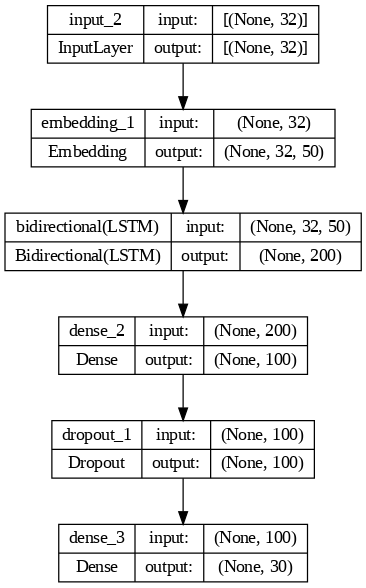

In [46]:
keras.utils.plot_model(bilstm_model, show_shapes=True, dpi=90)

In [47]:
bilstm_history = bilstm_model.fit(train_input,
                            train_labels,
                            validation_data=(valid_input, valid_labels),
                            batch_size=32,
                            epochs=20
                            )

Epoch 1/20
18750/18750 [==============================] - 163s 8ms/step - loss: 2.1592 - accuracy: 0.3589 - val_loss: 2.0054 - val_accuracy: 0.3944
Epoch 2/20
18750/18750 [==============================] - 136s 7ms/step - loss: 2.0117 - accuracy: 0.3945 - val_loss: 1.9506 - val_accuracy: 0.4045
Epoch 3/20
18750/18750 [==============================] - 135s 7ms/step - loss: 1.9633 - accuracy: 0.4061 - val_loss: 1.9222 - val_accuracy: 0.4138
Epoch 4/20
18750/18750 [==============================] - 136s 7ms/step - loss: 1.9355 - accuracy: 0.4140 - val_loss: 1.9065 - val_accuracy: 0.4206
Epoch 5/20
18750/18750 [==============================] - 136s 7ms/step - loss: 1.9169 - accuracy: 0.4185 - val_loss: 1.9019 - val_accuracy: 0.4185
Epoch 6/20
18750/18750 [==============================] - 135s 7ms/step - loss: 1.9010 - accuracy: 0.4225 - val_loss: 1.8983 - val_accuracy: 0.4227
Epoch 7/20
18750/18750 [==============================] - 138s 7ms/step - loss: 1.8891 - accuracy: 0.4255 - val_

In [48]:
test_predictions = bilstm_model.predict(test_input)

5368/5368 [==============================] - 17s 3ms/step


In [49]:
test_predictions

array([[6.59358921e-04, 1.72465201e-03, 7.28843268e-03, ...,
        6.41144142e-02, 1.23347854e-03, 3.06706857e-02],
       [2.14568479e-03, 3.86286956e-05, 8.20084068e-04, ...,
        2.33119190e-05, 1.65804086e-05, 2.52871658e-03],
       [2.00245879e-03, 5.33605646e-03, 7.52036180e-03, ...,
        1.13477267e-03, 1.30853215e-02, 1.04648073e-03],
       ...,
       [3.20311083e-05, 4.71795443e-03, 4.84714314e-04, ...,
        3.32277990e-03, 4.71040979e-03, 3.53048206e-03],
       [1.28878979e-03, 1.04186153e-02, 2.07637926e-03, ...,
        5.01630865e-02, 5.15530072e-02, 9.17264912e-03],
       [1.22051192e-02, 1.13199127e-03, 8.12538154e-03, ...,
        1.78878545e-04, 1.35545779e-05, 4.35392838e-03]], dtype=float32)

In [50]:
# Get the highest probability in the distribution for each prediction
test_predictions = tf.argmax(test_predictions, axis=-1)

In [51]:
print(classification_report(test_labels, test_predictions.numpy(), target_names=target_names))

                 precision    recall  f1-score   support

          4Head       0.62      0.46      0.53      1916
         4Weird       0.64      0.28      0.39       928
          5Head       0.91      0.03      0.06      1019
          AYAYA       0.69      0.43      0.53      3555
     BibleThump       0.67      0.07      0.12      2838
       DansGame       0.69      0.21      0.32      1703
       FailFish       0.85      0.29      0.43      1507
    FeelsBadMan       0.92      0.72      0.81      7153
   FeelsGoodMan       0.96      0.77      0.86      5694
           KEKW       0.36      0.56      0.44     37165
          Kappa       0.94      0.02      0.04      5683
       Kreygasm       0.72      0.16      0.26      2239
            LUL       0.31      0.53      0.39     35572
    MorphinTime       1.00      0.97      0.99      3592
    NotLikeThis       0.68      0.03      0.06      3347
     PauseChamp       0.88      0.06      0.11      1782
      PepeLaugh       0.74    

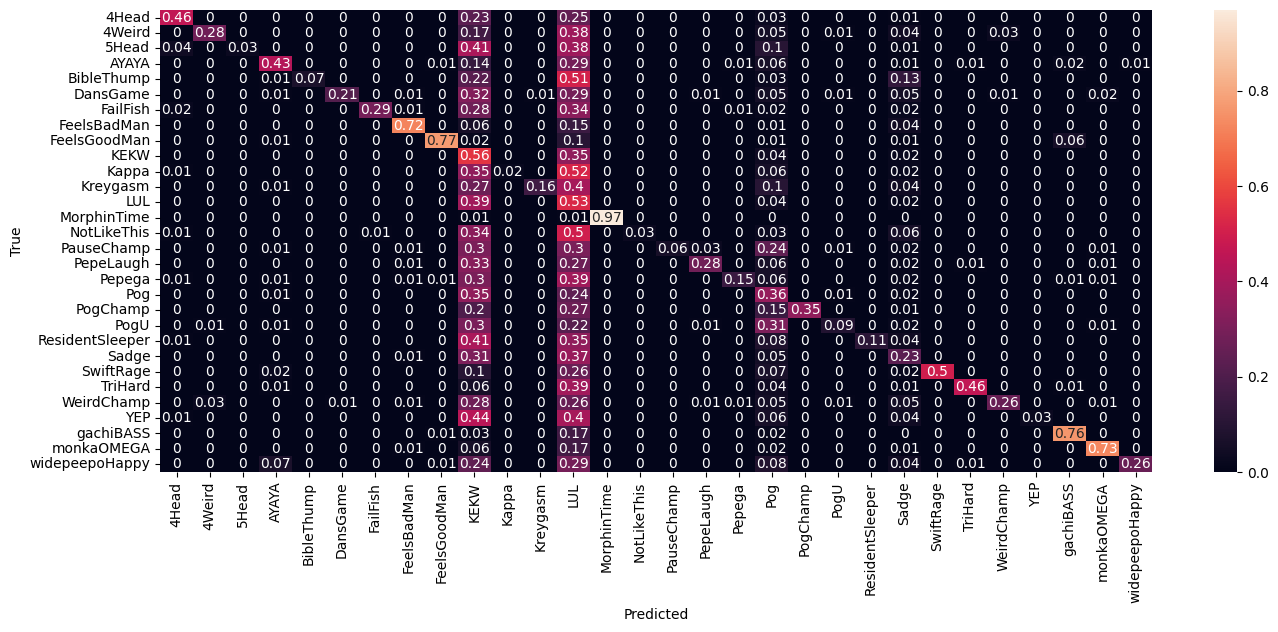

In [60]:
cm = tf.math.confusion_matrix(test_labels, test_predictions)
cm = np.around(cm/cm.numpy().sum(axis=1)[:, tf.newaxis], decimals=2)

plt.figure(figsize=(16,6))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()